In [ ]:
import glob
import shutil
import cv2 
from PIL import Image
import PIL
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random 
from sklearn.model_selection import train_test_split

import warnings
# Ignore waring
warnings.filterwarnings('ignore')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
emotion_path = ['/angry/*', '/disgust/*', '/fear/*', '/happy/*', '/sad/*', '/surprise/*', '/neutral/*']


In [ ]:
 train_path = '/content/drive/MyDrive/Machine Learning/emotions/train'


In [3]:
X = []
y= []
for i, path in enumerate(emotion_path):
  for name in glob.glob(train_path+path):
    img = cv2.imread(name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (50,50))
    X.append((img))
    y.append(i)
len(X)


NameError: ignored

In [ ]:
# chuyen du lieu sang narray()
X = np.array(X)
y = np.array(y)
print(X.shape)
print(y.shape)

(28821, 50, 50)
(28821,)


0


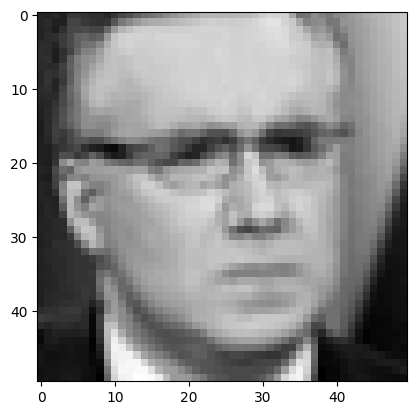

In [ ]:
print(y[0])
plt.imshow(X[0],cmap='gray')

Chia dữ liệu thành train và test

In [ ]:
(X_train,X_test,y_train,y_test) = train_test_split(X,y,test_size=0.2,random_state=100)

In [ ]:
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(23056, 50, 50) (5765, 50, 50)
(23056,) (5765,)


Normalize Input

In [ ]:
X_train = np.array([x.ravel()/255. for x in X_train ])
X_test = np.array([x.ravel()/255. for x in X_test])

print(X_train.shape)
print(X_test.shape)

(23056, 2500)
(5765, 2500)


Normalize output

In [ ]:
def one_hot_encode(y,num_classes):
  y_onehot = np.zeros((y.shape[0],num_classes))
  for i,label in enumerate(y):
    y_onehot[i][label] = 1
  return y_onehot

In [ ]:
y_train_onehot = one_hot_encode(y_train.reshape(-1,1),7)
y_test_onehot = one_hot_encode(y_test.reshape(-1,1),7)

In [ ]:
print(y_train_onehot[7])

[0. 0. 1. 0. 0. 0. 0.]


Build Model

In [ ]:
def softmax(z):
  return np.exp(z)/np.sum(np.exp(z),axis=1,keepdims =True)

In [ ]:
def predict(X,w):
  z = np.dot(X,w)
  y_pred = softmax(z)
  return y_pred

Hàm loss

In [ ]:
def loss(X,y,w):
  y_pred=predict(X,w)
  return -np.sum(y*np.log(y_pred+0.01))/y.shape[0]
  

Gradient descent

In [ ]:
def grad(x,y,w):
  y_pred = predict(x,w)
  delta = y_pred-y
  dw = np.dot(x.T,delta)/x.shape[0]
  return dw

Gradient Fullbatch

In [ ]:
def gradient_descent(x,y,lr,epochs):
  w =np.zeros((x.shape[1],y.shape[1]))
  l = loss(x,y,w)
  print("first loss ",l)
  history = []
  for i in range(epochs):
    dw = grad(x,y,w)
    w -= lr*dw
    a = loss(x,y,w)
    history.append(a)
  print("final loss = " , a )
  return history,w

Gradient MiniBatch

In [ ]:
def mini_batch_gradient(X,y,lr,epochs,batch_size):
  w = np.zeros((X.shape[1],y.shape[1]))
  l = loss(X,y,w)
  print("first loss ",l)
  loss_his = []
  for i in range(epochs):
    idx = np.random.choice(X.shape[0],batch_size,replace=False)
    X_batch = X[idx]
    y_batch = y[idx]
    dw = grad(X_batch,y_batch,w)/batch_size
    w -= dw*lr
    loss_his.append(loss(X_batch,y_batch,w))
  print("final loss = " , loss(X_batch,y_batch,w) )
  return loss_his,w


Train Full Batch

In [ ]:
his_full,w_full = gradient_descent(X_train,y_train_onehot,0.01,500)

first loss  1.8782515005814988
final loss =  1.6363030846897761


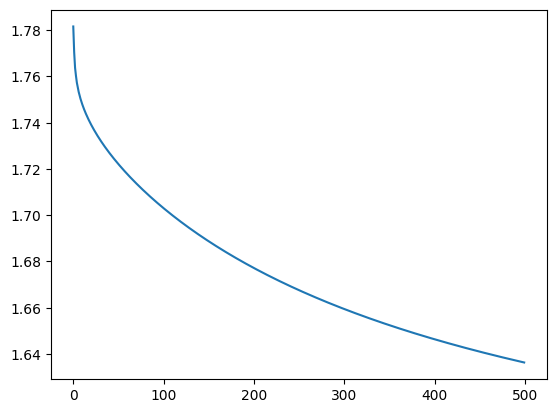

In [ ]:
plt.plot(his_full)

Train mini batch

In [ ]:
his_mini,w_mini = mini_batch_gradient(X_train,y_train_onehot,0.1,500,128)

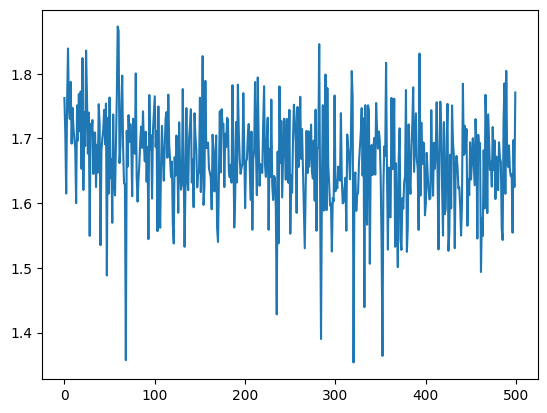

In [ ]:
plt.plot(his_mini)

In [ ]:
#
def batch_generator(X,y,batch_size = 32):
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    
    n_batch = len(idx)//batch_size # lấy phần nguyên 
    for i in range(n_batch):
        i_start = i*batch_size 
        i_stop = min((i+1)*batch_size,len(idx))
        X_batch = X[i_start:i_stop,:]
        y_batch = y[i_start:i_stop,:]
        yield X_batch, y_batch

EX1 : Evaluation 

In [ ]:
# Chuyển về dạng số thực 

def predict_classes(x,w):
  y_pred = predict(x,w)
  y_pred = np.argmax(y_pred,axis=1)
  return y_pred

In [ ]:
def evaluation(y_true, y_pred):
    tp = 0
    tn = 0 
    fp = 0 
    fn = 0 
    for i in range(len(y_true)):
        if(y_true[i] == y_pred[i]):
            if(y_pred[i] == 1):
                tp += 1
            else:
                tn += 1
        else:
            if(y_pred[i] == 1):
                fp += 1
            else:
                fn += 1
    accuracy = (tp + tn) / (tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2*precision*accuracy/(precision+accuracy)

    print("Accuracy = ",accuracy )
    print("Precision = ",precision )
    print("Recall = ",recall )
    print("f1_score = ",f1_score )

    

In [ ]:
def evaluation2(y_pred, y_true):
# Calculate precision and recall for each class
  labels = np.unique(y_true)
  label_len = len(labels)
  accuracy = np.zeros(len(labels))
  precision = np.zeros(len(labels))
  recall = np.zeros(len(labels))
  f1_score = np.zeros(7)
  for i in range(7):
    label = labels[i]
    tp = np.sum((y_pred == label) & (y_true == label))
    tn = np.sum((y_pred != label) & (y_true != label))
    fp = np.sum((y_pred == label) & (y_true != label))
    fn = np.sum((y_pred != label) & (y_true == label))
    accuracy[i] = (tp+tn)/(tp+tn+fp+fn) if (tp+tn+fp+fn) != 0 else 0
    precision[i] = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall[i] = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1_score[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i])
  #if(precision[i] + recall[i]) != 0 else 0
  accuracy_avg = np.mean(accuracy)
  precision_avg = np.mean(precision)
  recall_avg = np.mean(recall)
  f1_avg = np.mean(f1_score)
  print(f'tp = {tp}, tn = {tn}, fp = {fp}, fn = {fn}')
  print(f'Accuracy: {accuracy_avg}, Precsion: {precision_avg}, Recall:{recall_avg}, F1 Score: {f1_avg}')


In [ ]:
y_pred_train = predict(X_test, w_full)
y_pred_train = np.argmax(y_pred_train, axis=1)
print(y_pred_train.shape)

(5765,)


In [ ]:
evaluation2(y_pred_train,y_test)

tp = 283, tn = 4190, fp = 549, fn = 743
Accuracy: 0.8091438483459299, Precsion: 0.2623810796565889, Recall:0.24343181204594283, F1 Score: nan
